# Statistical physics of graphs and networks
## *Project:* study of the configuration model of random graphs
### *Master in physics of complex systems*
Joseph Touzet

We first import a few packages:

In [1]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
import scipy.optimize as opt
import copy

We will use _networkx_ to manage and plot networks.

We also define the parameter for ploting networks:

In [2]:
options = {
    "with_labels": False,
    "node_size": 3,
    "node_color": "black",
    "edgecolors": "black",
    "linewidths": 2,
    "width": 3,
}

def plot_graph(gr):
    pos = nx.nx_agraph.graphviz_layout(gr, prog="neato")
    
    C = (gr.subgraph(c) for c in nx.connected_components(gr))
    for g in C:
        c = [np.random.random()] * nx.number_of_nodes(g)  # random color...
        nx.draw(g, pos, node_size=40, node_color=c, vmin=0.0, vmax=1.0, with_labels=False)

### Problem 1: Generation of instances of the random graph model

First we will implement a few utility functions:

In [3]:
def choose_and_pop_from_list(items):
    index = random.randrange(len(items))
    return items.pop(index)

And then move on to the main asked functions:

In [4]:
def gen_rgm(N, pi):
    G = nx.Graph()
    for i in range(N):
        G.add_node(i)

    n_d1 = int(np.round(N*(1 - pi)/2)*2) # so that n_d1 + 4*n_d4 is pair
    n_d4 = N - n_d1

    stubs = []
    for i in range(n_d1):
        stubs.append(i)
    for i in range(n_d1, N):
        for j in range(4):
            stubs.append(i)
    
    while stubs:
        j = choose_and_pop_from_list(stubs)
        k = choose_and_pop_from_list(stubs)
        G.add_edge(j, k)
        G.add_edge(k, j)

    return G

def gen_rgm_biased(N, pi):
    G = nx.Graph()
    for i in range(N):
        G.add_node(i)

    n_d1 = int(np.round(N*(1 - pi)/2)*2) # so that n_d1 + 4*n_d4 is pair

    # use a dictionary of degrees
    degree = {}
    for i in range(N):
        degree[i] = 1 if i < n_d1 else 4
    
    while len(degree) >= 2:
        unique_stubs = list(degree.keys())

        # select a node and remove it from the temporary list of nodes to select from
        j = choose_and_pop_from_list(unique_stubs)
        while True:
            # try to select another node and remove it from the temporary list
            k = choose_and_pop_from_list(unique_stubs)
            # only add edge if there isn't already an edge
            if not G.has_edge(j, k):
                G.add_edge(j, k)
                G.add_edge(k, j)

                # delete both index
                degree[j] -= 1
                # and if the degree is 0 remove the entry from the dict
                if degree[j] == 0:
                    del degree[j]
                    
                degree[k] -= 1
                if degree[k] == 0:
                    del degree[k]

                break
            # if there is no more node to choose from:
            elif len(unique_stubs) == 0:
                # delete the entry for j because we know that we weren't able to create an edge from j
                del degree[j]
                break

    return G

Which we then test:

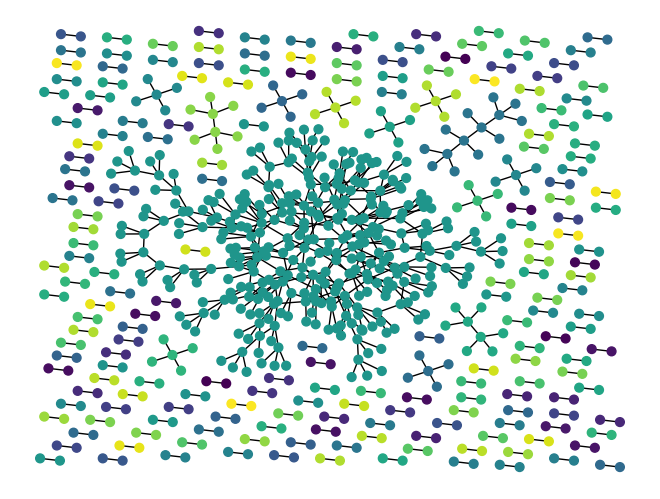

In [5]:
size, pi = 800, 0.2
graph = gen_rgm_biased(size, pi)

plot_graph(graph)

plt.savefig("./presentation/images/generated_graph.png")

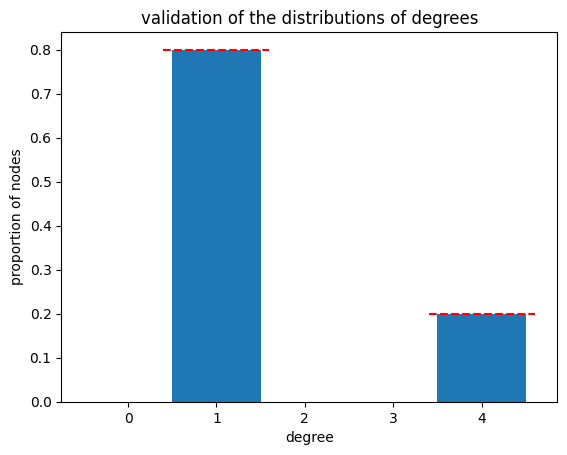

In [6]:
degree_list = [graph.degree[i] for i in range(len(graph))]

plt.hist(degree_list, density=True, bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
plt.plot([0.4, 1.6], [1-pi, 1-pi], 'r--')
plt.plot([3.4, 4.6], [pi,   pi],   'r--')

plt.title("validation of the distributions of degrees")
plt.xlabel("degree")
plt.ylabel("proportion of nodes")

plt.savefig("./presentation/images/degree_distribution.png")
plt.show()

## Problem 2: The giant component

We first need a function that (recursivly) walks through a graph to get the connected component starting from a given node:

In [7]:
def get_connected_component(graph, node, visited=None):
    if visited is None:
        visited = []
    visited.append(node)
    
    for neighbor in graph.neighbors(node):
        if neighbor not in visited:
            connected = get_connected_component(graph, neighbor, visited)
            
            for connected_node in connected:
                if connected_node not in visited:
                    visited.append(connected_node)
    return visited

We then use this function to efficently go through connected components (once per connected components), and return the largest connected components once there is not enough nodes to hope to find another even larger connected component:

In [8]:
def find_largest_connected_component(graph):
    n_nodes     = graph.number_of_nodes()
    not_visited = list(graph.nodes)
    
    largest_connected_component = []
    while True:
        starting_node = not_visited[0]
        connected_component = get_connected_component(graph, starting_node)

        for node in connected_component:
            not_visited.remove(node)

        if len(connected_component) >= len(largest_connected_component):
            largest_connected_component = connected_component
            
        if len(not_visited) <= len(largest_connected_component):
            return largest_connected_component

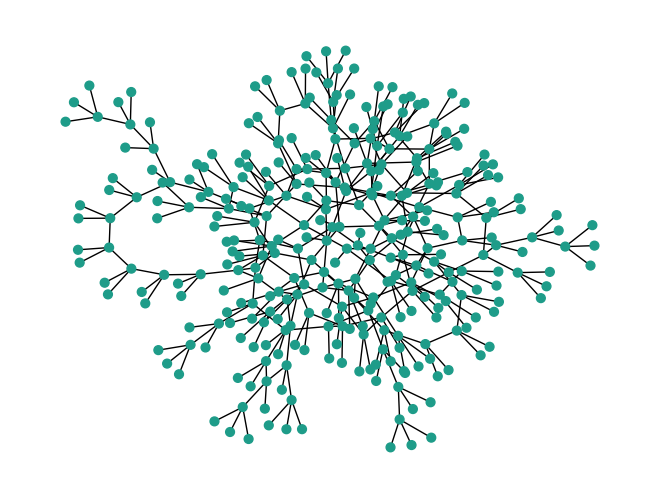

In [9]:
largest_connected_component = find_largest_connected_component(graph)
largest_connected_subgraph = graph.subgraph(largest_connected_component)

plot_graph(largest_connected_subgraph)

plt.savefig("./presentation/images/generated_graph_giant_connected_component.png")

(a) We can now plot the average proportion of nodes inside of the giant component versus the value of $\pi$:

We here use a depth first search as we recursively search through the graph.

In [10]:
Ns, sizes = [200, 20, 10], [20, 100, 500]
pis = np.linspace(0, 1, 15)

avg_size = []
for N,size in zip(Ns,sizes):
    avg_size.append([])
    for pi in pis:
        avg_size[-1].append(0)
        for n in range(N):
            graph = gen_rgm_biased(size, pi)
            largest_connected_component = find_largest_connected_component(graph)
            avg_size[-1][-1] += len(largest_connected_component)
        avg_size[-1][-1] /= N*size

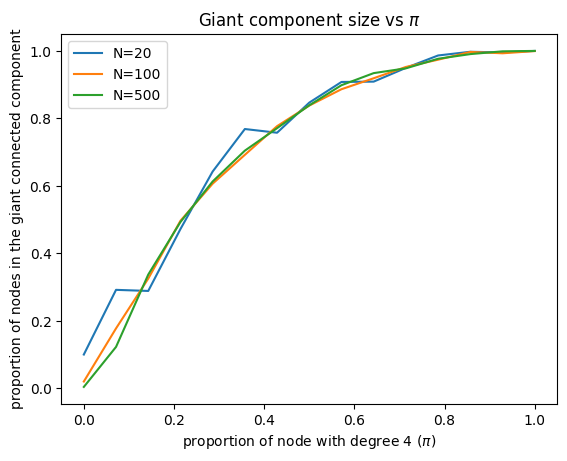

In [11]:
for size,curve in zip(sizes, avg_size):
    plt.plot(pis, curve, label=f"N={ size }")

plt.title(r"Giant component size vs $\pi$")
plt.xlabel(r"proportion of node with degree 4 ($\pi$)")
plt.ylabel("proportion of nodes in the giant connected component")

plt.legend()
plt.show()

We observe that for increasing N (at least for our limited sample range) the curve doesn't evolve too much.

### 2-b: Theoretical analysis:

Concidering a node $i$, we want to know the probability that is it not in the giant connected component (which we will denote GCC from now on). If any of its neighbor are not in the GCC, then itself and all other neighbor are by definition also not in the GCC. Given $\sigma$ the probability that a node is in the GCC. We will write $q_d$ the probability for a node to have degree $d$ conditined on the fact that it has a degree $d \geq 1$. <br>
$$
\sigma = \sum_{d=0}^{+\infty} q_{d+1} \sigma^d  = q_1 + q_4 \sigma^3
$$
Given $\gamma$ the probability for a node to be in the GCC <br>
$$
1 - \gamma = \sum_{d=0}^{+\infty} p_d \sigma^d = p_1 + p_4 \sigma^4
$$
By definition of $q_d$:
$$
q_d = \frac{d p_d}{\sum_{q=0}^{+\infty} d p_d}\\
q_1 = \frac{1-\pi}{1+3\pi}\\
q_4 = \frac{4\pi}{1+3\pi}\\
$$
We deduce the equations:

$$ \gamma = 1 - \sigma \left[ \left( 1 -\pi \right) + \pi \sigma^3 \right] $$
$$ 0 = 1 - \pi - \left( 1+3 \pi \right) \sigma + 4 \pi \sigma^3 $$
$$ 0 = \left( \sigma -1 \right) \left( 4 \pi \sigma^2 + 4 \pi \sigma - 1 + \pi \right) $$

We can compute the solutions of the system as:
$$
\sigma = 1\; or\; \sigma = \frac{-1 \pm \frac{1}{\sqrt{\pi}}}{2}
$$
and 
$$
\gamma = 0\\
$$
$$
\gamma = 1 - \frac{ - 1 \pm \frac{1}{ \sqrt{\pi} } }{2} \left( 1 - \pi + \pi \left( \frac{-1 \pm \frac{1}{\sqrt{\pi} } }{2} \right)^3 \right)
$$
The solution must be a probability $\gamma, \sigma \in \left[0, 1\right]$. So we will only keep the solutions:
$$
\sigma = 0\; or\; \sigma = \frac{\frac{1}{\sqrt{\pi}}-1}{2}
$$

In [12]:
def p_giant(pi):
    eps = 1e-18
    if pi == 0:
        return 0
    
    return max(0,
               1 - (1/np.sqrt(pi) - 1)/2 * (1 - pi + pi*((1/np.sqrt(pi) -1 ) / 2)**3))

(c) We can now compare the theoretical giant component size with our experimental results:

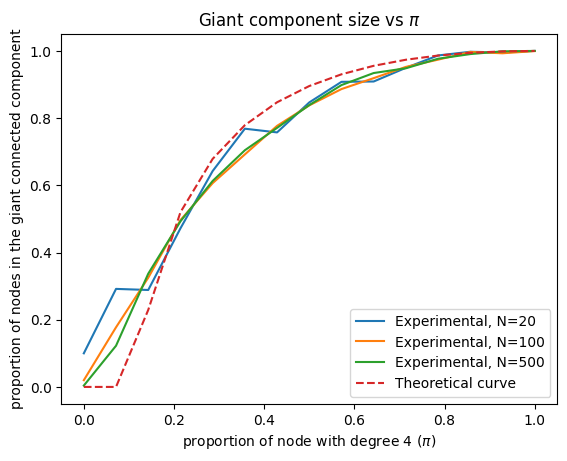

In [13]:
for size,curve in zip(sizes, avg_size):
    plt.plot(pis, curve, label=f"Experimental, N={ size }")

plt.plot(pis, [p_giant(pi) for pi in pis], "--", label="Theoretical curve")

plt.title(r"Giant component size vs $\pi$")
plt.xlabel(r"proportion of node with degree 4 ($\pi$)")
plt.ylabel("proportion of nodes in the giant connected component")

plt.legend()

plt.savefig("./presentation/images/giant-connected-component.png")
plt.show()

We see that the experimental curbe is non-zero for small p whereas our theoretically derived curve is zero for $\pi < \pi_0$ with some $\pi_0 > 0$.

We also observe that for all the N with tested, for small $\pi$ our experimental results gives us bigger average giant connected component, wheareas for $\pi$ closer to 1 we see the oposit with a higher theoreticl prediction.

We still observe the same quantization effect.

### Problem 3: Emergence of the 3-core

In [14]:
def find_k_core(graph, k): # prunning algorithm
    G = copy.deepcopy(graph)
    while True:
        to_remove=[]
        
        for node in G.nodes:
            if G.degree[node] < k:
                to_remove.append(node)
            
        if len(to_remove) == 0:
            if len(G.nodes) == 0:
                return []
            
            # the k-core still has to be a single connected graph
            k_core = find_largest_connected_component(G)
            return k_core

        for node in to_remove:
            G.remove_node(node)

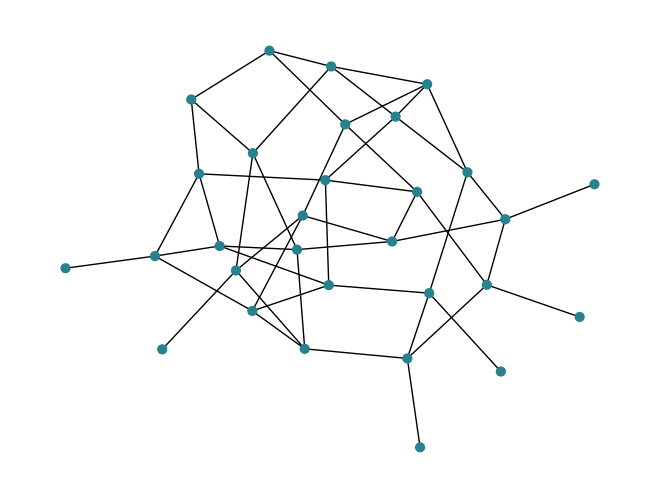

In [15]:
graph = gen_rgm_biased(30, 0.8)

plot_graph(graph)

plt.savefig("./presentation/images/generated_graph2.png")

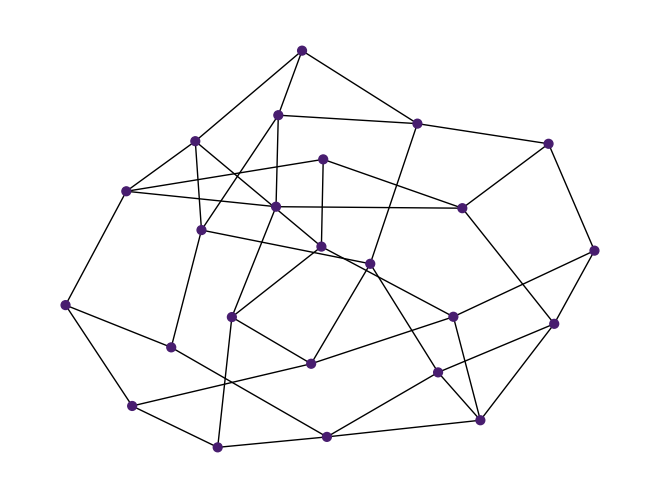

In [16]:
core3_component = find_k_core(graph, 3)
core3_subgraph = graph.subgraph(core3_component)

plot_graph(core3_subgraph)

plt.savefig("./presentation/images/generated_graph2_3core.png")

(a) We can now plot the average proportion of nodes inside of the giant component versus the value of $\pi$:

In [17]:
Ns, sizes = [200, 100, 30], [20, 100, 500]
pis = np.linspace(0, 1, 15)

avg_size_3core = []
for N,size in zip(Ns,sizes):
    avg_size_3core.append([])
    for pi in pis:
        avg_size_3core[-1].append(0)
        for n in range(N):
            graph = gen_rgm_biased(size, pi)
            k_core = find_k_core(graph, 3)
            avg_size_3core[-1][-1] += len(k_core)
        avg_size_3core[-1][-1] /= N*size

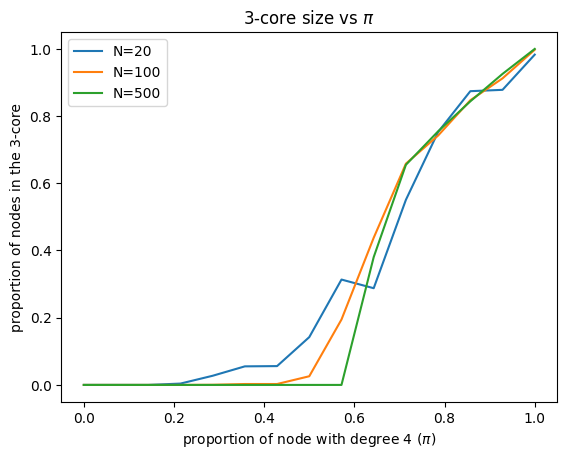

In [18]:
for size,curve in zip(sizes, avg_size_3core):
    plt.plot(pis, curve, label=f"N={ size }")

plt.title(r"3-core size vs $\pi$")
plt.xlabel(r"proportion of node with degree 4 ($\pi$)")
plt.ylabel("proportion of nodes in the 3-core")

plt.legend()
plt.show()

...

### 3-b: Theoretical analysis:

We know from the course that the probability that a vertex is in the q-core is:

$ F_{q}(\beta_F) = 1 - \sum_{d=0}^{q-1} e^{-\beta_F} \frac{\beta_F^d}{d !} $

<br> With $\beta_F$ is the fixed point of the map $ \frac{ \beta_{i+1} }{c} = F_{q-1} (\beta_{i}) $ and $c$ is the average degree of the verteces $c = \left<d\right> = \frac{1}{N} \sum_{i=1}^{N} d_i$

In our case, we obtain:
 - $F_3 = 1 - e^{-\beta_F} \left( 1+ \beta_F + \frac{\beta_F^2}{2} \right)$
 - $ \frac{\beta_F}{1 + 3\pi} = 1 - e^{-\beta_F} \left( 1 + \beta_F \right) $
 - $ c = 1-\pi + 4\pi = 1 + 3 \pi $

We thus implement a function that returns the fraction of nodes in the 3-core, and the parameter $\beta_F$:

In [19]:
def Three_Core_Theory(pi):
    def F2(beta):
        return 1 - np.exp(-beta)*(1 + beta)
    def F3(beta):
        return 1 - np.exp(-beta)*(1 + beta + beta**2*0.5)
    def beta_func(beta, pi):
        return beta/(1 + 3*pi)

    # function and its derivatives for 
    func      = lambda beta,pi: beta_func(beta, pi) - F2(beta)
    dfdbeta   = lambda beta,pi: 1/(1 + 3*pi) - np.exp(-beta)*beta
    df2dbeta2 = lambda beta,pi: np.exp(-beta)*(beta - 1)

    try:
        Beta = opt.newton(func, 4., fprime=dfdbeta, fprime2=df2dbeta2, args=(pi,))
    except: # If error return the (0,0) solution
        return 0., 0.

    return F3(Beta), Beta

(c) We can now compare the theoretical giant component size with our experimental results:

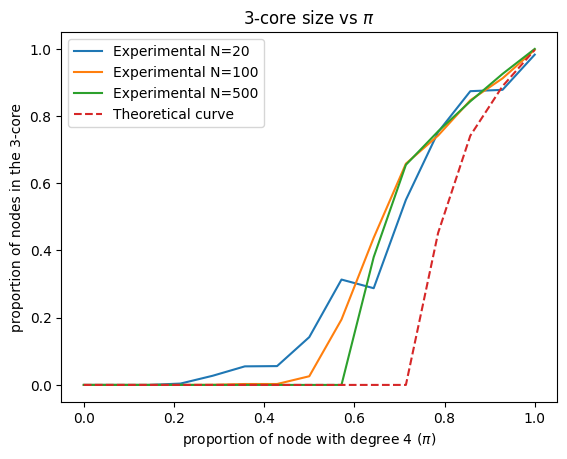

In [20]:
for size,curve in zip(sizes, avg_size_3core):
    plt.plot(pis, curve, label=f"Experimental N={ size }")

plt.plot(pis, [Three_Core_Theory(pi)[0]*3/2 for pi in pis], "--", label="Theoretical curve")

plt.title(r"3-core size vs $\pi$")
plt.xlabel(r"proportion of node with degree 4 ($\pi$)")
plt.ylabel("proportion of nodes in the 3-core")

plt.legend()

plt.savefig("./presentation/images/3-core.png")
plt.show()

We see that for higher N the $\pi_0$ at which the 3-core emerges (the average size of the 3 core becomes non-zero) is pushed toward the high-$\pi$, and thus toward our theoretically-derrived curve.

### Problem 4: The ferromagnetic Ising model

In [21]:
def gen_random_state(N_node, p=0.5):
    random_state = np.random.rand(N_node)
    state = 2*(random_state < p) - 1
    return state

def get_state_magnetisation(state):
    return np.mean(state)

In [22]:
def monte_carlo_simulate(graph, state, T, N_it_per_node):
    n_nodes = graph.number_of_nodes()
    
    for i in range(n_nodes*N_it_per_node):
        node = np.random.randint(0, n_nodes)
        
        total_surounding_spin = 0
        for neighbor in graph.neighbors(node):
            total_surounding_spin += state[neighbor]
        
        delta_E = 2*state[node]*total_surounding_spin
        if delta_E < 0:
            state[node] = -state[node]
        else:
            P_flip = np.exp(-delta_E/T)
            if np.random.rand() < P_flip:
                state[node] = -state[node]
        
    return state

In [23]:
graph = gen_rgm_biased(100, 0.8)
state = gen_random_state(100)

print(get_state_magnetisation(monte_carlo_simulate(graph, state, 10, 100)))
print(get_state_magnetisation(monte_carlo_simulate(graph, state, 0.5, 100)))

0.06
1.0


(1) TODO

In [24]:
N, size, n_it = 30, 50, 100
Ts = np.linspace(0.5, 8, 30)

graph = gen_rgm_biased(size, 0.8)

magnetisations = []
for T in Ts:
    magnetisations.append([])
    for i in range(N):
        state = gen_random_state(100)
        final_state   = monte_carlo_simulate(graph, state, T, n_it)
        magnetisation = get_state_magnetisation(final_state)
        
        magnetisations[-1].append(magnetisation)

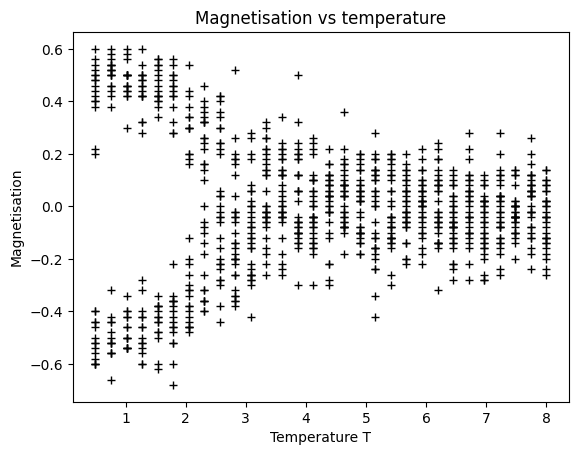

In [25]:
for T,mag in zip(Ts, magnetisations):
    plt.plot([T]*N, mag, "k+")
    
plt.title("Magnetisation vs temperature")
plt.xlabel(r"Temperature T")
plt.ylabel("Magnetisation")

plt.savefig("./presentation/images/magnetisation.png")
plt.show()

We here can see a phase transition from $m=\pm m_{eq}$ to $m=0$ at $T \approx 3$.

In [26]:
N, size, n_it = 10, 50, 100
pis = np.linspace(0, 1, 20)
Ts  = np.linspace(0.5, 5, 20)

PIS, TS = np.meshgrid(pis, Ts)

avg_m = np.zeros_like(PIS)
for i in range(PIS.shape[0]):
    for j in range(PIS.shape[1]):
        for n in range(N):
            graph = gen_rgm_biased(size, PIS[i, j])
            state = gen_random_state(size)
            
            equilibirum_state = monte_carlo_simulate(graph, state, TS[i, j], n_it)
            
            avg_m[i, j] += abs(get_state_magnetisation(equilibirum_state))
avg_m /= N

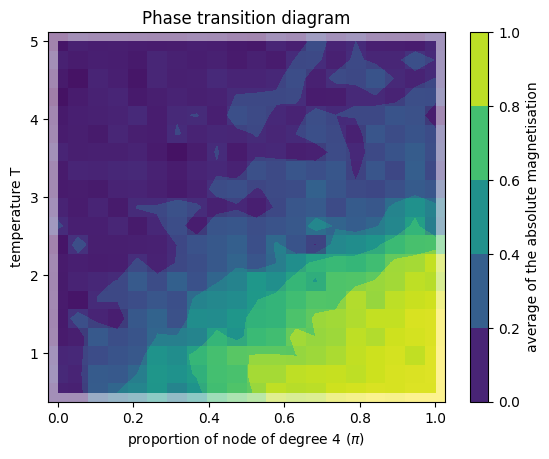

In [27]:
plt.contourf(PIS, TS, avg_m, 5)
plt.colorbar(label="average of the absolute magnetisation")
plt.pcolormesh(PIS, TS, avg_m, alpha=0.5)

plt.title("Phase transition diagram")
plt.xlabel(r"proportion of node of degree 4 ($\pi$)")
plt.ylabel("temperature T")

plt.savefig("./presentation/images/phase_transition_diagram.png")
plt.show()

(2) We can now study the 

(3) TODO

### Problem 5: Inverse Ising model

(1) We can run our Monte Carlo simulation on a large set of starting state, until equilibrium, and all on a single constant graph to then test to infer the graph from the statistical properties of the set of equilibrium states.

In [201]:
size, T, pi = 50, 4, 0.4
N, n_it = 500, 100

graph = gen_rgm_biased(size, pi)

In [202]:
states = np.zeros((N, size))
for n in range(N):
    state = gen_random_state(size)
    equilibirum_state = monte_carlo_simulate(graph, state, T, n_it)
    states[n, :] = equilibirum_state

In [203]:
correlations = np.zeros((size, size))
avgs = np.mean(states, axis=0)

for i in range(size):
    for j in range(i+1):
        for n in range(N):
            correlations[i, j] += states[n, i]*states[n, j]
        correlations[i, j] /= N
        
        correlations[i, j] -= avgs[i]*avgs[j]
        correlations[j, i]  = correlations[i, j]

pairs = []
for i in range(size):
    for j in range(i):
        pairs.append((i, j))

cor_pairs = zip([correlations[pair] for pair in pairs], pairs)
cor_pairs_sorted = reversed(sorted(cor_pairs))
pairs_sorted = [pair for cor,pair in cor_pairs_sorted]

In [204]:
n_predictions = np.arange(1, int(graph.number_of_edges()*2))
prediction_acc = np.zeros_like(n_predictions, dtype=float)

for i in range(len(n_predictions)):
    for pair in pairs_sorted[:n_predictions[i]]:
        prediction_acc[i] += float(graph.has_edge(pair[0], pair[1]))
    prediction_acc[i] = float(prediction_acc[i])/n_predictions[i]

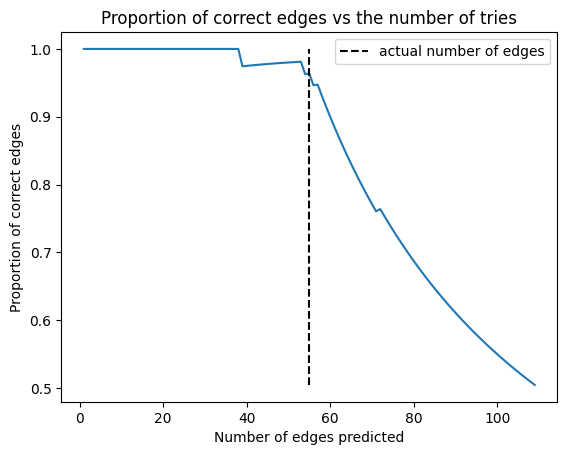

In [205]:
plt.plot(n_predictions, prediction_acc)

plt.plot([graph.number_of_edges(), graph.number_of_edges()],
         [min(prediction_acc), max(prediction_acc)],
         "k--", label="actual number of edges")

plt.title("Proportion of correct edges vs the number of tries")
plt.xlabel("Number of edges predicted")
plt.ylabel("Proportion of correct edges")

plt.legend()

plt.savefig("./presentation/images/reconstruction_accuracy_plot.png")
plt.show()

We  see that almost all the most correlated pairs are correctly identified as connected pairs.

(2) We can now compute the infered connection matrix $J_{ij} = (C^{-1})_{ij}$.

In [206]:
Jij = np.linalg.inv(correlations)

J_pairs = zip([Jij[pair] for pair in pairs], pairs)
J_pairs_sorted = sorted(J_pairs)
pairs_sorted = [pair for J,pair in J_pairs_sorted]

In [207]:
n_predictions = np.arange(1, min(len(pairs_sorted), int(graph.number_of_edges()*2)))
prediction_acc = np.zeros_like(n_predictions, dtype=float)

for i in range(len(n_predictions)):
    for pair in pairs_sorted[:n_predictions[i]]:
        prediction_acc[i] += float(graph.has_edge(pair[0], pair[1]))
    prediction_acc[i] = float(prediction_acc[i])/n_predictions[i]

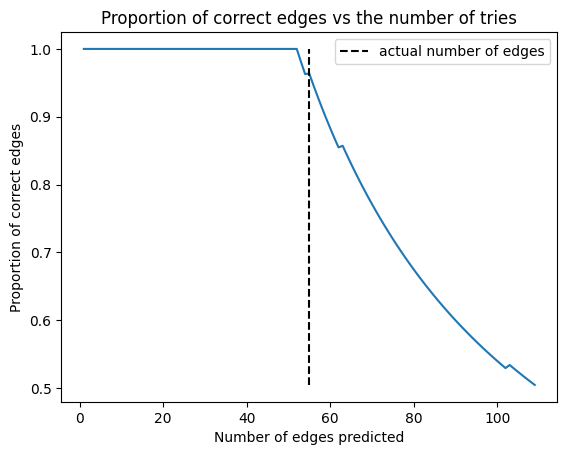

In [208]:
plt.plot(n_predictions, prediction_acc)

plt.plot([graph.number_of_edges(), graph.number_of_edges()],
         [min(prediction_acc), max(prediction_acc)],
         "k--", label="actual number of edges")

plt.title("Proportion of correct edges vs the number of tries")
plt.xlabel("Number of edges predicted")
plt.ylabel("Proportion of correct edges")

plt.legend()

plt.savefig("./presentation/images/reconstruction_accuracy_meanField.png")
plt.show()

We  see that almost all the lost $J_{ij}$ (negative $J_{ij}$) pairs are correctly identified as connected pairs.

(3) We can know plot histogram of both $J_{ij}$ and $C_{ij}$ for both connected and unconnected nodes:

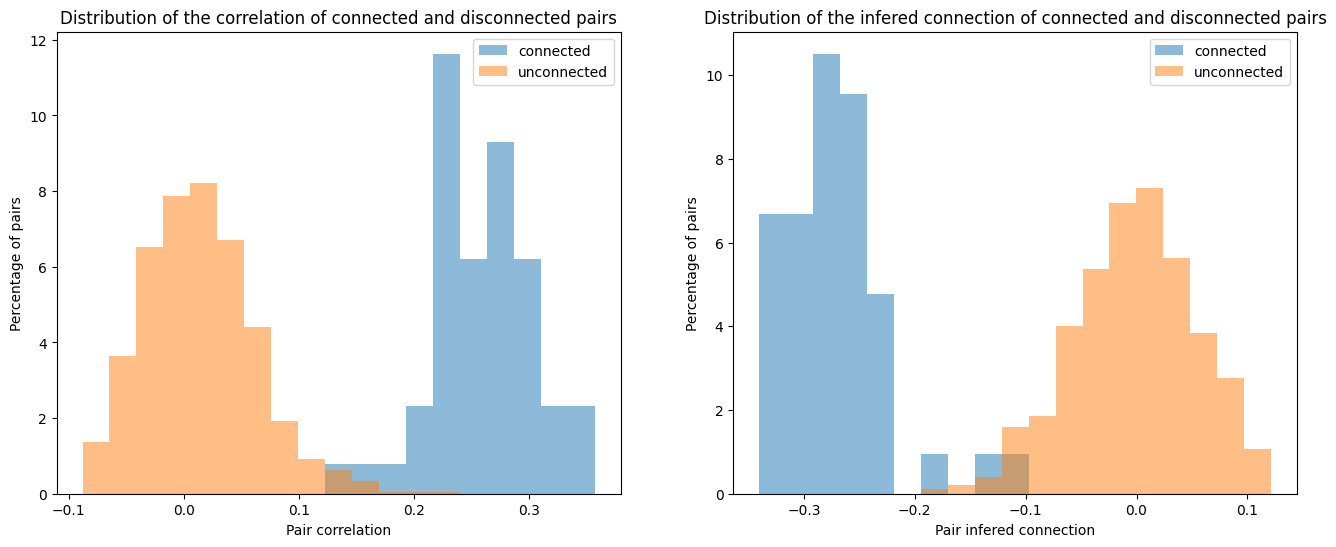

In [209]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

bins = np.linspace(*np.percentile(correlations.flatten(), (1, 98)), 20)

connected_pairs   = [correlations[pair] for pair in pairs if     graph.has_edge(pair[0], pair[1])]
unconnected_pairs = [correlations[pair] for pair in pairs if not graph.has_edge(pair[0], pair[1])]

ax[0].hist(connected_pairs,   bins, alpha=0.5, label="connected",   density=True)
ax[0].hist(unconnected_pairs, bins, alpha=0.5, label="unconnected", density=True)

ax[0].set_title("Distribution of the correlation of connected and disconnected pairs")
ax[0].set_xlabel("Pair correlation")
ax[0].set_ylabel("Percentage of pairs")

ax[0].legend()

bins = np.linspace(*np.percentile(Jij.flatten(), (1, 97)), 20)

connected_pairs   = [Jij[pair] for pair in pairs if     graph.has_edge(pair[0], pair[1])]
unconnected_pairs = [Jij[pair] for pair in pairs if not graph.has_edge(pair[0], pair[1])]

ax[1].hist(connected_pairs,   bins, alpha=0.5, label="connected",   density=True)
ax[1].hist(unconnected_pairs, bins, alpha=0.5, label="unconnected", density=True)

ax[1].set_title("Distribution of the infered connection of connected and disconnected pairs")
ax[1].set_xlabel("Pair infered connection")
ax[1].set_ylabel("Percentage of pairs")

ax[1].legend()

fig.savefig("./presentation/images/histogram_correlations.png")

We can observe in the previous two figures that there is a large separation of connected and unconnected pairs, both in terme of correlation $C_{ij}$ and infered connection $J_{ij}$.